# Predictive & Supervised ML Forecasting Models

## Imported Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator, WeekdayLocator, MO
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

## 8 Variables

Working with 5 and 30 minute resolutions with the start time of "6/1/17 0:00" and end time of "6/30/17 23:55", there are 8 variables we will explore analyze their relationships. They are below, their definitions, and units:

- Time Stamps (UTC): format='%m/%d/%y %H:%M'
- PV Power Outputs of Residential of a Single Rooftop Solar Panels (watts)
- Ambient Temperature (°C)
- Wind Speed at 10 m above MSL (m/s)
- Wind Direction at 10 m above MSL (degrees)
- Direct Normal Irradiance (DNI): the component that is involved in thermal (concentrating solar power, CSP) and photovoltaic concentration technology (concentrated photovoltaic, CPV).
- Global Horizontal Irradiance (GHI): the sum of direct and diffuse radiation received on a horizontal plane. GHI is a reference radiation for the comparison of climatic zones; it is also essential parameter for calculation of radiation on a tilted plane.
- Global Tilt Irradiance (GTI): total radiation received on a surface with defined tilt and azimuth, fixed or sun-tracking. This is the sum of the scattered radiation, direct and reflected. It is a reference for photovoltaic (PV) applications, and can be occasionally affected by shadow.

---

### Correlation Matrix (5 min resolution)

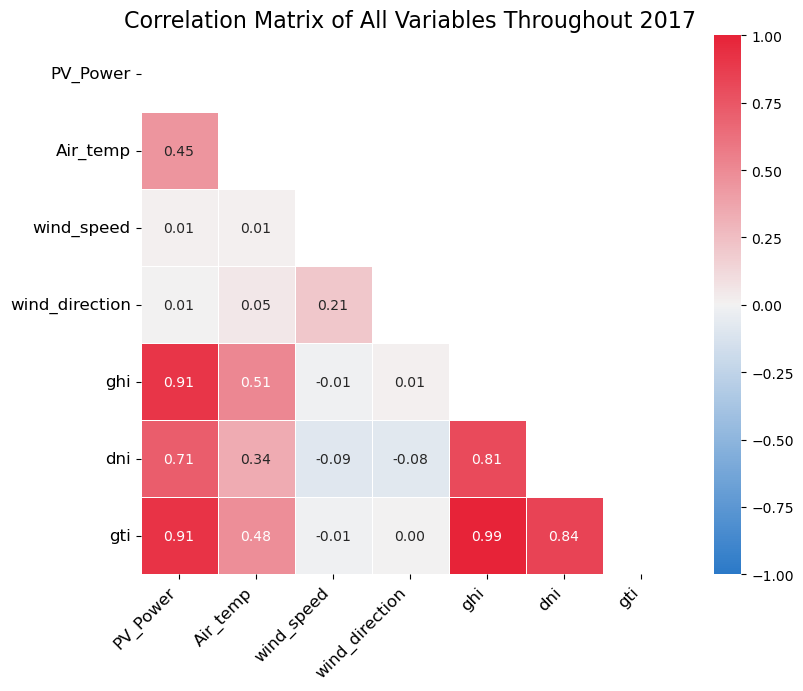

In [2]:
# Load the data from the CSV file
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert the TimeStamp column to datetime format
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter the data for the specified date range
start_time = '1/1/17 0:00'
end_time = '12/31/17 23:55'
mask = (data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)
filtered_data = data.loc[mask]

# Drop the TimeStamp column for the correlation matrix calculation
correlation_data = filtered_data.drop(columns=['TimeStamp'])

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Define the color map
cmap = sns.diverging_palette(250, 10, s=90, l=50, as_cmap=True)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix with the specified formatting
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": 1.0},
            annot_kws={"size": 10})
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Correlation Matrix of All Variables Throughout 2017', fontsize=16)

plt.show()

### Variables with Significant Correlation with each other (ranked from greatest to least in correlation coefficient)

ghi with gti (0.99):
There is an almost perfect positive correlation between global horizontal irradiance and global tilted irradiance. This suggests that both irradiance measures are nearly identical in behavior and likely influenced by the same factors.

PV_Power with ghi (0.91):
A very strong positive correlation exists between PV power and global horizontal irradiance, indicating that as irradiance increases, PV power production significantly increases. This suggests that irradiance is a major factor influencing PV power output.

PV_Power with gti (0.91):
A very strong positive correlation between PV power and global tilted irradiance suggests that as tilted irradiance increases, PV power output also significantly increases. This is expected as tilted irradiance directly impacts the solar panels.

dni with gti (0.84):
A strong positive correlation exists between direct normal irradiance and global tilted irradiance. This indicates that increases in direct irradiance are closely associated with increases in tilted irradiance, reflecting similar environmental conditions.

ghi with dni (0.81):
A strong positive correlation between global horizontal irradiance and direct normal irradiance suggests that these two types of irradiance increase together significantly. This indicates consistent environmental conditions affecting both measures.

PV_Power with dni (0.71):
There is a strong positive correlation between PV power and direct normal irradiance. This indicates that higher direct irradiance levels are closely associated with increased PV power production.

Air_temp with ghi (0.51):
A moderate positive correlation exists between air temperature and global horizontal irradiance, indicating that higher temperatures are often associated with increased irradiance. This relationship could be influenced by clear weather conditions that boost both temperature and irradiance.

Air_temp with gti (0.48):
A moderate positive correlation indicates that higher air temperatures are associated with increased global tilted irradiance. This might be due to similar environmental conditions affecting both variables.

PV_Power with Air_temp (0.45):
There is a moderate positive correlation between PV power and air temperature, suggesting that higher temperatures are associated with increased PV power output. This relationship could be influenced by other environmental factors as well.

Air_temp with dni (0.34):
There is a moderate positive correlation between air temperature and direct normal irradiance. This suggests that higher temperatures are associated with increased direct irradiance, likely due to clearer skies.

---

### Varying Regression Models (Scatterplots) - 5 min resolution (more points mean more accuracy) 

Based on the correlation coefficients above, I will work with producing linear and other regression plots for the first 6 (equal to 0.71 or above) throughout 2017

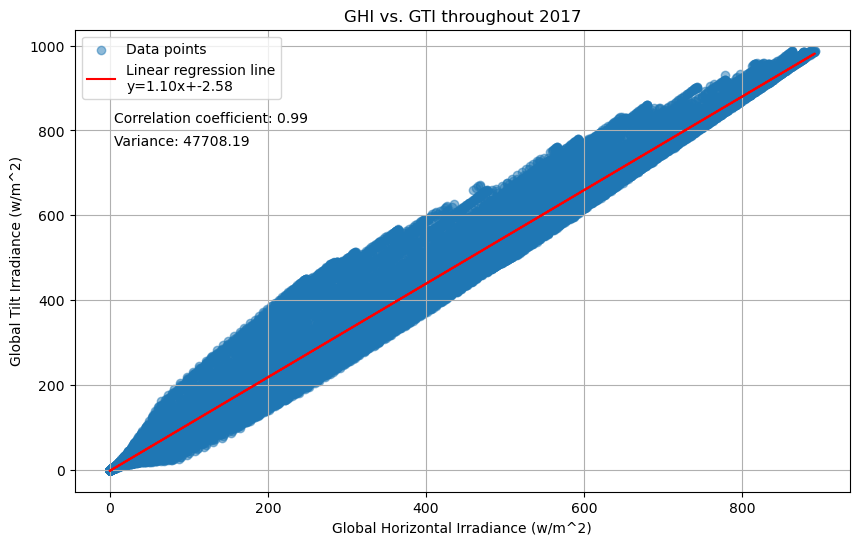

In [3]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['ghi'], filtered_data['gti'], alpha=0.5, label='Data points')

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['ghi'], filtered_data['gti'])
line = slope * filtered_data['ghi'] + intercept
plt.plot(filtered_data['ghi'], line, color='red', label=f'Linear regression line\ny={slope:.2f}x+{intercept:.2f}')

# Annotations
plt.xlabel('Global Horizontal Irradiance (w/m^2)')
plt.ylabel('Global Tilt Irradiance (w/m^2)')
plt.title('GHI vs. GTI throughout 2017')
plt.legend()
plt.grid(True)

# Display correlation coefficient and variance
correlation_coefficient = np.corrcoef(filtered_data['ghi'], filtered_data['gti'])[0, 1]
variance = np.var(filtered_data['gti'])
plt.text(0.05, 0.80, f'Correlation coefficient: {correlation_coefficient:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.75, f'Variance: {variance:.2f}', transform=plt.gca().transAxes)

# Show plot
plt.show()

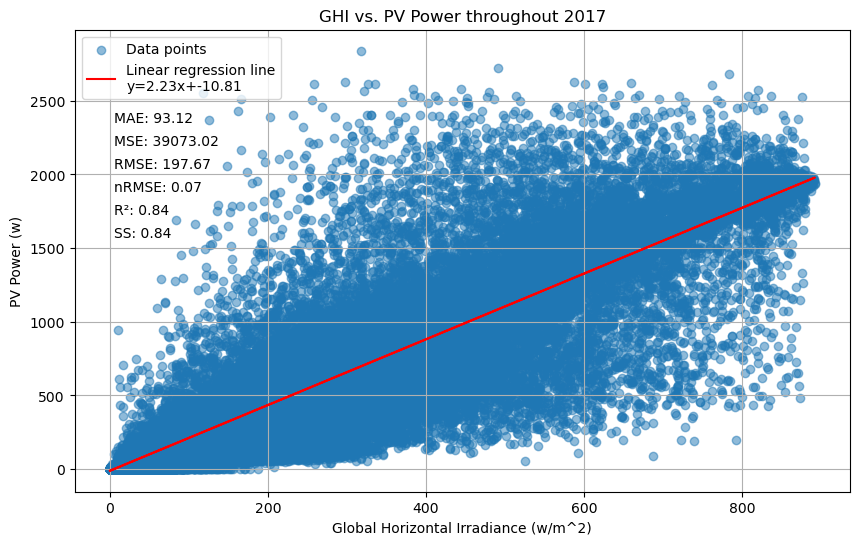

In [4]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Remove rows with missing PV_Power values
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['ghi'], filtered_data['PV_Power'], alpha=0.5, label='Data points')

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['ghi'], filtered_data['PV_Power'])
line = slope * filtered_data['ghi'] + intercept
plt.plot(filtered_data['ghi'], line, color='red', label=f'Linear regression line\ny={slope:.2f}x+{intercept:.2f}')

# Extract the true and predicted values
y_true = filtered_data['PV_Power']
y_pred = slope * filtered_data['ghi'] + intercept

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
nrmse = rmse / (y_true.max() - y_true.min())
r2 = r2_score(y_true, y_pred)
y_naive_pred = np.full_like(y_true, np.mean(y_true))
skill_score = 1 - (mse / mean_squared_error(y_true, y_naive_pred))

# Annotations
plt.xlabel('Global Horizontal Irradiance (w/m^2)')
plt.ylabel('PV Power (w)')
plt.title('GHI vs. PV Power throughout 2017')
plt.legend()
plt.grid(True)

# Display metrics on the plot
plt.text(0.05, 0.80, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.75, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.70, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.65, f'nRMSE: {nrmse:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.60, f'R²: {r2:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.55, f'SS: {skill_score:.2f}', transform=plt.gca().transAxes)

# Show plot
plt.show()

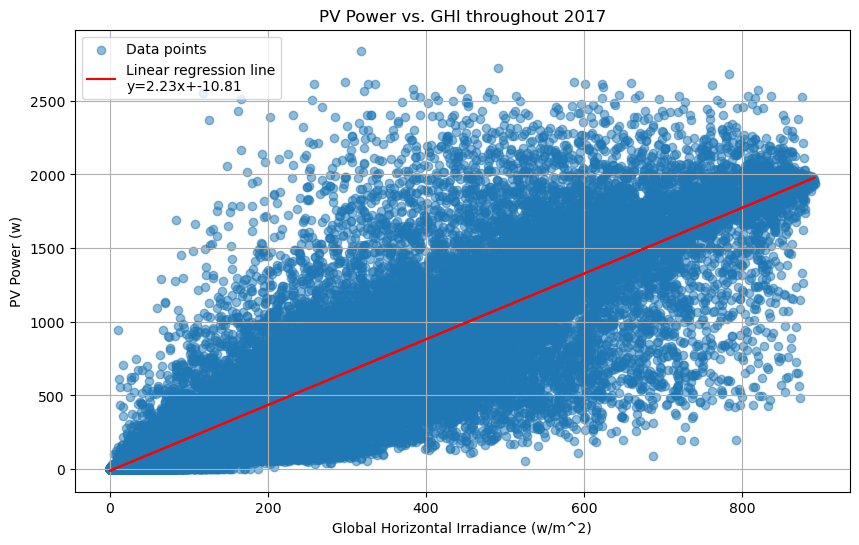

In [20]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Remove rows with missing PV_Power values
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['ghi'], filtered_data['PV_Power'], alpha=0.5, label='Data points')

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['ghi'], filtered_data['PV_Power'])
line = slope * filtered_data['ghi'] + intercept
plt.plot(filtered_data['ghi'], line, color='red', label=f'Linear regression line\ny={slope:.2f}x+{intercept:.2f}')

# Extract the true and predicted values
y_true = filtered_data['PV_Power']
y_pred = slope * filtered_data['ghi'] + intercept

# Annotations
plt.xlabel('Global Horizontal Irradiance (w/m^2)')
plt.ylabel('PV Power (w)')
plt.title('PV Power vs. GHI throughout 2017')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

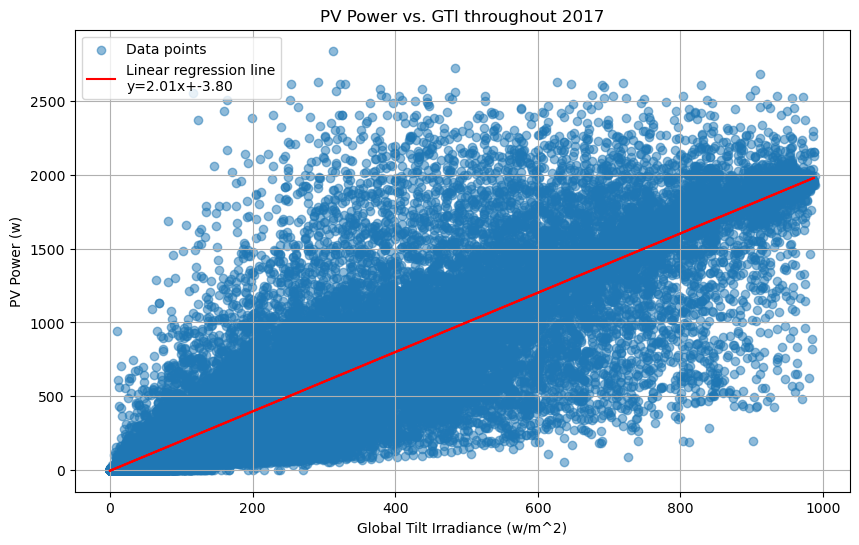

In [17]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Remove rows with missing PV_Power values
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['gti'], filtered_data['PV_Power'], alpha=0.5, label='Data points')

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['gti'], filtered_data['PV_Power'])
line = slope * filtered_data['gti'] + intercept
plt.plot(filtered_data['gti'], line, color='red', label=f'Linear regression line\ny={slope:.2f}x+{intercept:.2f}')

# Annotations
plt.xlabel('Global Tilt Irradiance (w/m^2)')
plt.ylabel('PV Power (w)')
plt.title('PV Power vs. GTI throughout 2017')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

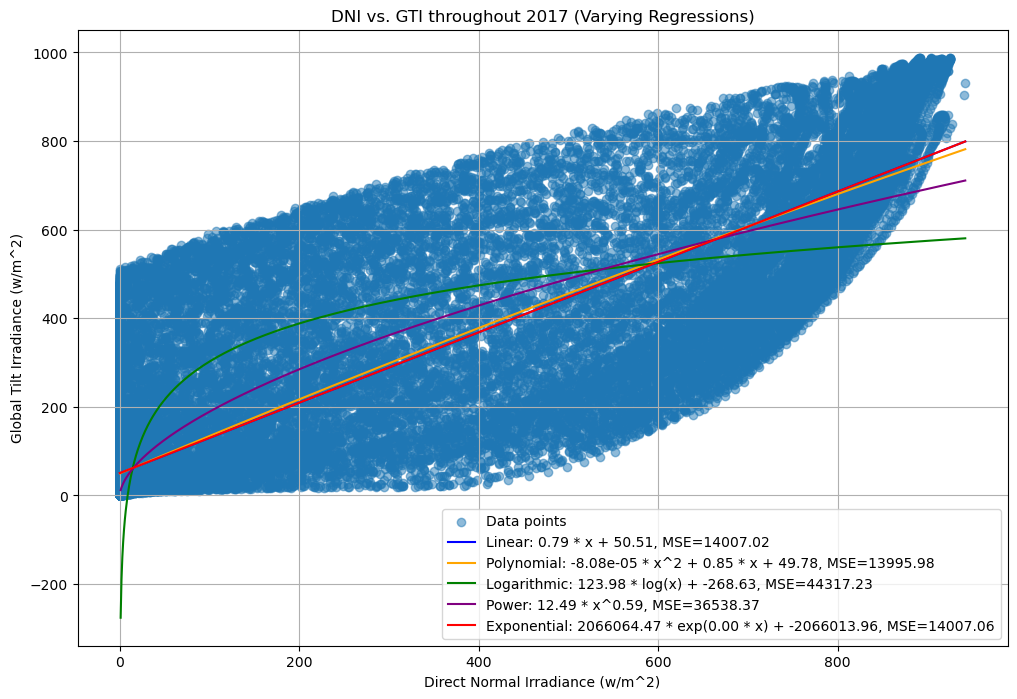

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

x_data = filtered_data['dni']
y_data = filtered_data['gti']

# Linear regression
linear_params = np.polyfit(x_data, y_data, 1)
linear_fit = np.polyval(linear_params, x_data)
linear_mse = mean_squared_error(y_data, linear_fit)
linear_eq = f'{linear_params[0]:.2f} * x + {linear_params[1]:.2f}'

# Polynomial regression (degree 2)
poly_params = np.polyfit(x_data, y_data, 2)
poly_fit = np.polyval(poly_params, x_data)
poly_mse = mean_squared_error(y_data, poly_fit)
poly_eq = f'{poly_params[0]:.2e} * x^2 + {poly_params[1]:.2f} * x + {poly_params[2]:.2f}'

# Logarithmic regression
def log_func(x, a, b):
    return a * np.log(x) + b

log_params, _ = curve_fit(log_func, x_data[x_data > 0], y_data[x_data > 0])
log_fit = log_func(x_data[x_data > 0], *log_params)
log_mse = mean_squared_error(y_data[x_data > 0], log_fit)
log_eq = f'{log_params[0]:.2f} * log(x) + {log_params[1]:.2f}'

# Power regression
def power_func(x, a, b):
    return a * np.power(x, b)

power_params, _ = curve_fit(power_func, x_data[x_data > 0], y_data[x_data > 0])
power_fit = power_func(x_data[x_data > 0], *power_params)
power_mse = mean_squared_error(y_data[x_data > 0], power_fit)
power_eq = f'{power_params[0]:.2f} * x^{power_params[1]:.2f}'

# Exponential regression
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

exp_params, _ = curve_fit(exp_func, x_data, y_data, p0=[1, 0.01, 1], maxfev=5000)
exp_fit = exp_func(x_data, *exp_params)
exp_mse = mean_squared_error(y_data, exp_fit)
exp_eq = f'{exp_params[0]:.2f} * exp({exp_params[1]:.2f} * x) + {exp_params[2]:.2f}'

# Plotting the results
plt.figure(figsize=(12, 8))
plt.scatter(x_data, y_data, alpha=0.5, label='Data points')

x_fit = np.linspace(x_data.min(), x_data.max(), 1000)

# Plot each regression line
plt.plot(x_fit, np.polyval(linear_params, x_fit), label=f'Linear: {linear_eq}, MSE={linear_mse:.2f}', color='blue')
plt.plot(x_fit, np.polyval(poly_params, x_fit), label=f'Polynomial: {poly_eq}, MSE={poly_mse:.2f}', color='orange')
plt.plot(x_fit[x_fit > 0], log_func(x_fit[x_fit > 0], *log_params), label=f'Logarithmic: {log_eq}, MSE={log_mse:.2f}', color='green')
plt.plot(x_fit[x_fit > 0], power_func(x_fit[x_fit > 0], *power_params), label=f'Power: {power_eq}, MSE={power_mse:.2f}', color='purple')
plt.plot(x_fit, exp_func(x_fit, *exp_params), label=f'Exponential: {exp_eq}, MSE={exp_mse:.2f}', color='red')

# Annotations
plt.xlabel('Direct Normal Irradiance (w/m^2)')
plt.ylabel('Global Tilt Irradiance (w/m^2)')
plt.title('DNI vs. GTI throughout 2017 (Varying Regressions)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

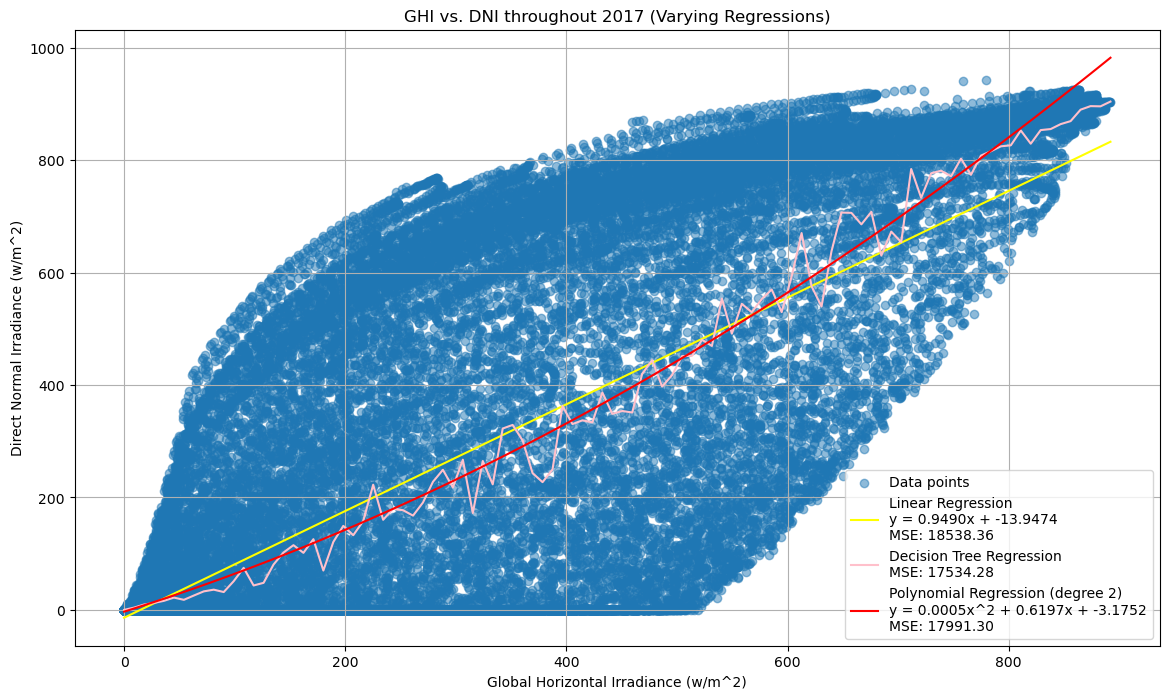

In [7]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Prepare the data
X = filtered_data['ghi'].values.reshape(-1, 1)
y = filtered_data['dni'].values

# Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
y_pred_linear = linear_regressor.predict(X)
linear_eq = f'y = {linear_regressor.coef_[0]:.4f}x + {linear_regressor.intercept_:.4f}'

# Decision Tree Regression
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X, y)
y_pred_tree = tree_regressor.predict(X)
# Decision Tree regression does not have a simple equation

# Polynomial Regression (degree 2)
z = np.polyfit(filtered_data['ghi'], filtered_data['dni'], 2)
p = np.poly1d(z)
y_pred_poly = p(X)
poly_eq = f'y = {z[0]:.4f}x^2 + {z[1]:.4f}x + {z[2]:.4f}'

# Calculate Mean Squared Error
mse_linear = mean_squared_error(y, y_pred_linear)
mse_tree = mean_squared_error(y, y_pred_tree)
mse_poly = mean_squared_error(y, y_pred_poly)

# Scatter plot
plt.figure(figsize=(14, 8))

# Plot data points
plt.scatter(X, y, alpha=0.5, label='Data points')

# Plot regression lines
x_range = np.linspace(filtered_data['ghi'].min(), filtered_data['ghi'].max(), 100)
plt.plot(x_range, linear_regressor.predict(x_range.reshape(-1, 1)), color='yellow', 
         label=f'Linear Regression\n{linear_eq}\nMSE: {mse_linear:.2f}')
plt.plot(x_range, tree_regressor.predict(x_range.reshape(-1, 1)), color='pink', 
         label=f'Decision Tree Regression\nMSE: {mse_tree:.2f}')
plt.plot(x_range, p(x_range), color='red', 
         label=f'Polynomial Regression (degree 2)\n{poly_eq}\nMSE: {mse_poly:.2f}')

# Annotations
plt.xlabel('Global Horizontal Irradiance (w/m^2)')
plt.ylabel('Direct Normal Irradiance (w/m^2)')
plt.title('GHI vs. DNI throughout 2017 (Varying Regressions)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

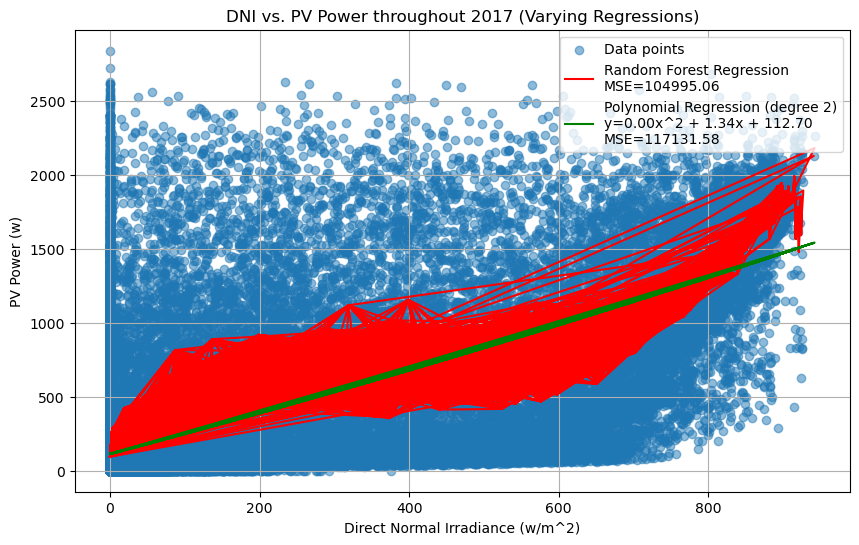

In [8]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Drop rows where PV_Power is missing
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['dni'], filtered_data['PV_Power'], alpha=0.5, label='Data points')

# Random Forest Regression
X_rf = filtered_data[['dni']].values
y_rf = filtered_data['PV_Power'].values
rf = RandomForestRegressor()
rf.fit(X_rf, y_rf)
y_pred_rf = rf.predict(X_rf)
mse_rf = mean_squared_error(y_rf, y_pred_rf)

# Polynomial Regression (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rf)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y_rf)
y_pred_poly = poly_reg.predict(X_poly)
mse_poly = mean_squared_error(y_rf, y_pred_poly)

# Polynomial Regression equation
coefs = poly_reg.coef_
intercept = poly_reg.intercept_
poly_eq = f'y={coefs[2]:.2f}x^2 + {coefs[1]:.2f}x + {intercept:.2f}'

# Add plots
plt.plot(filtered_data['dni'], y_pred_rf, color='red', label=f'Random Forest Regression\nMSE={mse_rf:.2f}')
plt.plot(filtered_data['dni'], y_pred_poly, color='green', label=f'Polynomial Regression (degree 2)\n{poly_eq}\nMSE={mse_poly:.2f}')

# Annotations
plt.xlabel('Direct Normal Irradiance (w/m^2)')
plt.ylabel('PV Power (w)')
plt.title('DNI vs. PV Power throughout 2017 (Varying Regressions)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

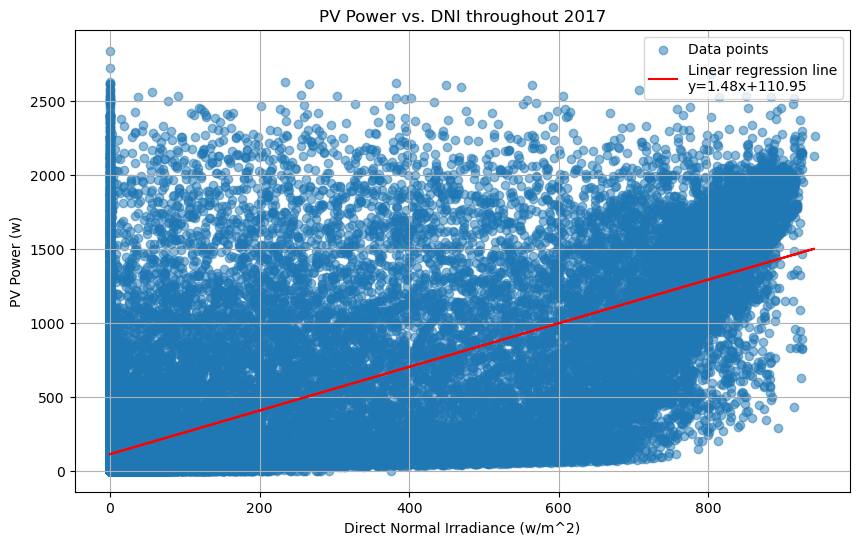

In [18]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data by date range
start_time = '2017-01-01 00:00:00'
end_time = '2017-12-31 23:55:00'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Drop rows where PV_Power is missing
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['dni'], filtered_data['PV_Power'], alpha=0.5, label='Data points')

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['dni'], filtered_data['PV_Power'])
line = slope * filtered_data['dni'] + intercept
plt.plot(filtered_data['dni'], line, color='red', label=f'Linear regression line\ny={slope:.2f}x+{intercept:.2f}')

# Annotations
plt.xlabel('Direct Normal Irradiance (w/m^2)')
plt.ylabel('PV Power (w)')
plt.title('PV Power vs. DNI throughout 2017')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

---

### Line Graphs (PV Power vs. Time)
##### Time Bounds: June 21 and Dec 21, 2017 (summer and wintern solstice for Utrecht, Netherlands in 2017) and June and December 2017

/var/folders/j6/g4_nh54s61724h3sb61kzrzh0000gn/T/ipykernel_24978/2726635925.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])


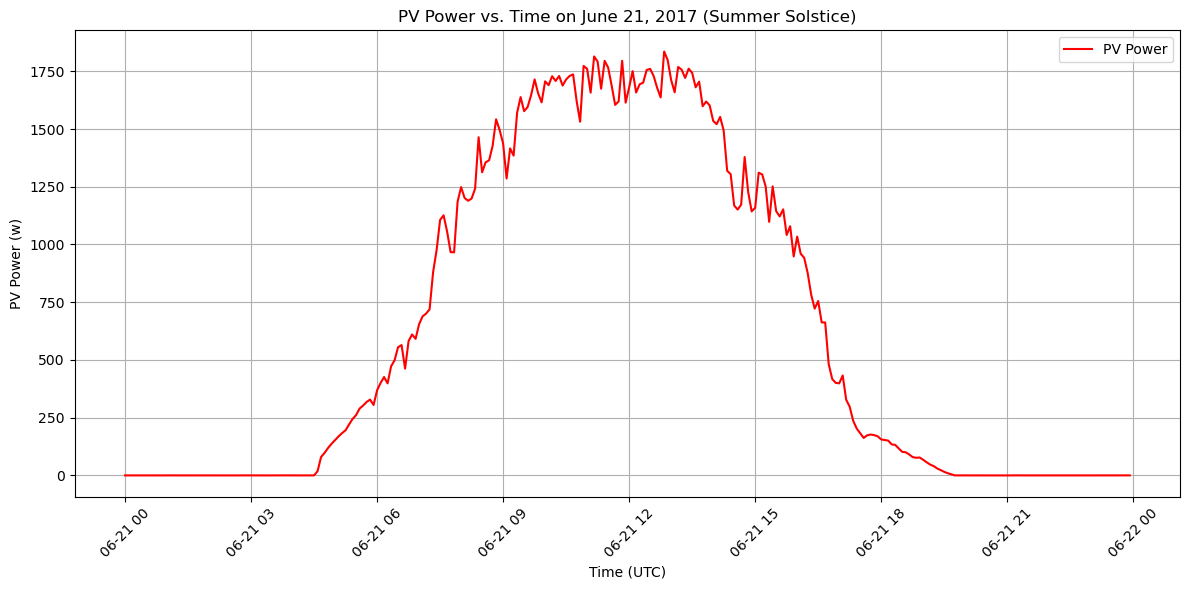

In [21]:
# Load the dataset
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert the 'TimeStamp' column to datetime format
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])

# Filter the data for the specified time range
start_time = '2017-06-21 00:00'
end_time = '2017-06-21 23:55'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Remove rows with missing 'PV_Power' values
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['TimeStamp'], filtered_data['PV_Power'], color='red', label='PV Power')
plt.xlabel('Time (UTC)')
plt.ylabel('PV Power (w)')
plt.title('PV Power vs. Time on June 21, 2017 (Summer Solstice)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

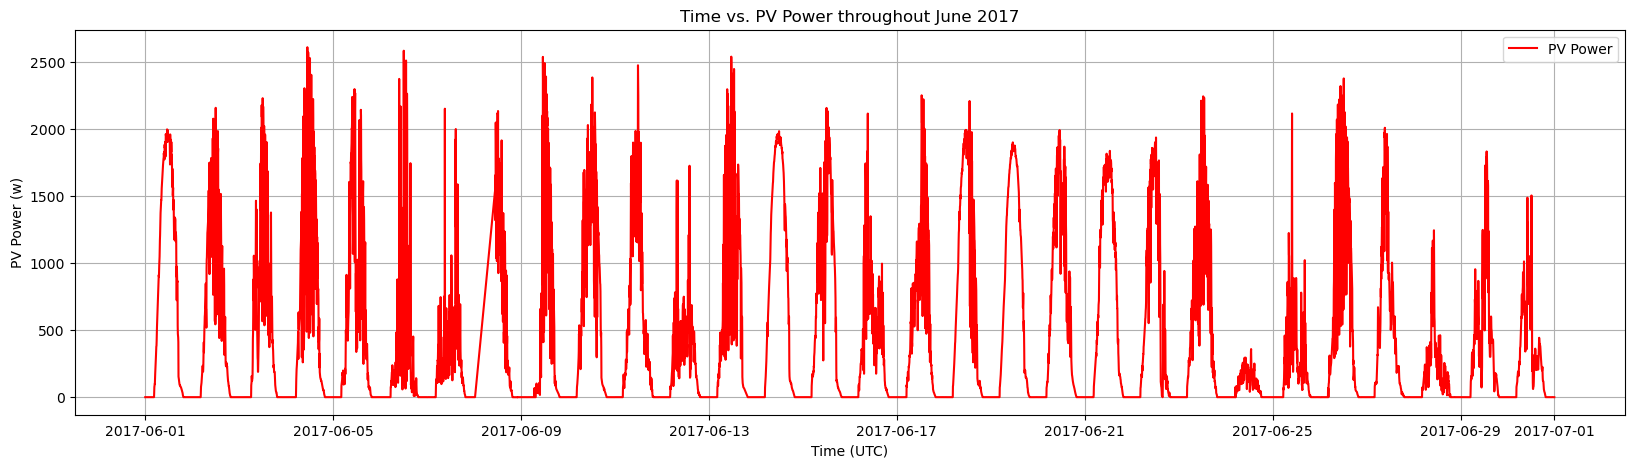

In [26]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert the TimeStamp to datetime
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')

# Filter data for the specified date range
start_time = '2017-06-01 00:00'
end_time = '2017-06-30 23:55'
mask = (data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)
filtered_data = data.loc[mask]

# Drop rows with missing PV_Power values
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(filtered_data['TimeStamp'], filtered_data['PV_Power'], color='red', label='PV Power')
plt.xlabel('Time (UTC)')
plt.ylabel('PV Power (w)')
plt.title('Time vs. PV Power throughout June 2017')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/j6/g4_nh54s61724h3sb61kzrzh0000gn/T/ipykernel_24978/1265668478.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])


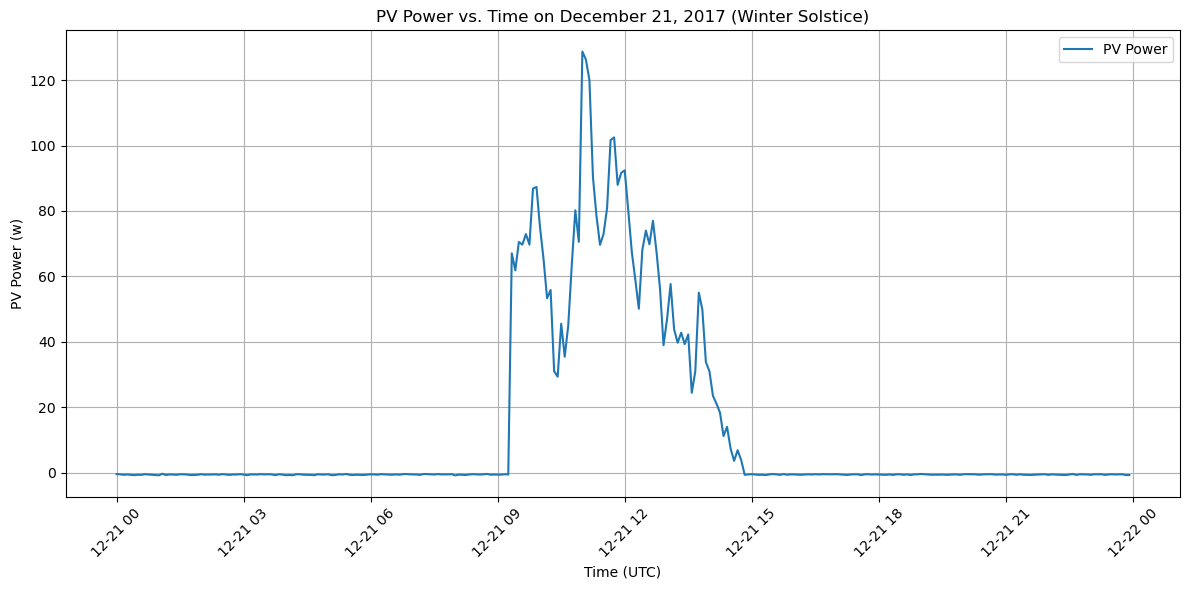

In [11]:
# Load the data from the CSV file
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert the TimeStamp column to datetime format
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])

# Filter the data for the specified time range
start_time = pd.to_datetime("12/21/17 0:00")
end_time = pd.to_datetime("12/21/17 23:55")
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Drop rows where PV_Power is missing
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['TimeStamp'], filtered_data['PV_Power'], label='PV Power')
plt.xlabel('Time (UTC)')
plt.ylabel('PV Power (w)')
plt.title('PV Power vs. Time on December 21, 2017 (Winter Solstice)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

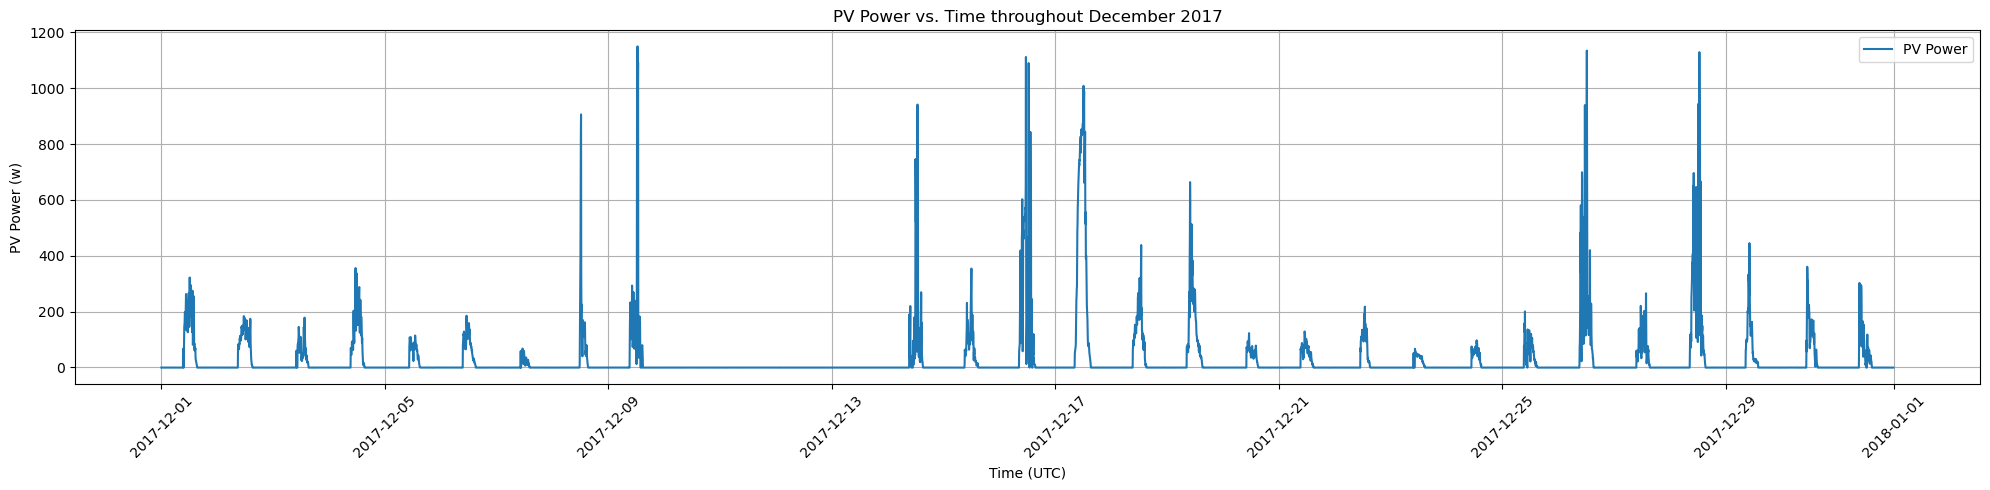

In [12]:
# Load the data
file_path = './FINAL_PV_POWER_5_MINS.csv'
data = pd.read_csv(file_path)

# Convert TimeStamp to datetime and filter the desired date range
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%m/%d/%y %H:%M')
start_time = '2017-12-01 00:00'
end_time = '2017-12-31 23:55'
filtered_data = data[(data['TimeStamp'] >= start_time) & (data['TimeStamp'] <= end_time)]

# Drop rows with missing PV_Power values
filtered_data = filtered_data.dropna(subset=['PV_Power'])

# Plotting the data
plt.figure(figsize=(20, 5))
plt.plot(filtered_data['TimeStamp'], filtered_data['PV_Power'], label='PV Power')
plt.xlabel('Time (UTC)')
plt.ylabel('PV Power (w)')
plt.title('PV Power vs. Time throughout December 2017')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()